In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install gymnasium
!pip install pygame

In [2]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379365 sha256=bcc252f1903f020198a5fe51ef61183a493327901a5c3d6f7f67130e346599ca
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [3]:
import gymnasium as gym

gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v3
LunarLander-v3         LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
Ant-v5                 HalfCheetah-v2         HalfCheetah-v3
HalfCheetah-v4         HalfCheetah-v5         Hopper-v2
Hopper-v3              Hopper-v4              Hopper-v5
Humanoid-v2            Humanoid-v3            Humanoid-v4
Humanoid-v5            HumanoidStandup-v2     HumanoidStandup-v4
HumanoidStandup-v5     InvertedDoublePendulum-v2 InvertedDoublePendulum-v4
InvertedDoublePendulu

In [4]:
import torch.nn as nn
import torch.optim as optim
import torch

class GaussianActorCritic(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(64, 64)):
        super().__init__()
        # shared layers
        self.share = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU()
        )

        # actor layers. actor_mean estimates the mean of the Gaussian distribution, and actor_log_std estimates the log_std
        self.actor_mean = nn.Linear(hidden_dims[1], output_dim)

        # log_std is safe from having negative values, therefore more stable than estimating std. Since action is bounded from -1 to 1, initialize it as e^-2
        self.actor_log_std = nn.Parameter(torch.ones(output_dim) * -2)

        # critic layer estimates value function
        self.critic = nn.Linear(hidden_dims[1], 1)

    def forward(self, x):
        x = self.share(x)

        # actor's mean layer estimates mean.
        mean = self.actor_mean(x)

        # actor's log_std layer estimates log_std. Then, convert it to std
        log_std = self.actor_log_std
        std = torch.exp(log_std)

        # critic layer estimates value
        value = self.critic(x)

        return mean, std, value


In [37]:
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import LambdaLR


class A2CAgent:
    def __init__(self, env_id, num_episodes=1000, max_steps=500, gamma=0.99, lr=1e-3, num_steps = 0, num_envs = 8, vectorization_mode = "sync"):
        # using vectorized environments to boost training
        # sync is more stable, async is faster
        self.env = gym.make_vec(env_id, num_envs = num_envs, vectorization_mode=vectorization_mode)
        self.num_envs = num_envs
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.gamma = gamma
        self.lr = lr
        # default num_steps is 0 which runs Monte Carlo
        self.num_steps = num_steps
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # DEBUG NOTE must use single_action_space, not action_space since action_space.shape has dimension (num_env, num_actions)
        # self.policy_net = GaussianActorCritic(self.env.single_observation_space.shape[0], self.env.action_space.shape[0]).to(self.device)
        self.policy_net = GaussianActorCritic(self.env.single_observation_space.shape[0], self.env.single_action_space.shape[0]).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.global_step = 0  # count optimizer steps

        def linear_decay(step):
            frac = 1.0 - min(step / (self.num_episodes), 1.0)
            return frac

        self.scheduler = LambdaLR(self.optimizer, lr_lambda=linear_decay)
        self.loss = nn.MSELoss()

    # choosing action from policy's probability distribution
    def choose_action(self, state):
        mean, std, value = self.policy_net(state)
        action_dist = torch.distributions.Normal(mean, std)
        raw_action = action_dist.rsample()
        squashed_action = torch.tanh(raw_action)

        # Correct log_prob for tanh squashing
        log_prob = action_dist.log_prob(raw_action).sum(dim=-1)
        log_prob -= torch.log(1 - squashed_action.pow(2) + 1e-6).sum(dim=-1)

        return squashed_action.detach(), log_prob, value


    # computing the gamma decaying rewards in Monte carlo
    def compute_return(self, rewards):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        return torch.stack(returns)

    # computing the n step rewards
    def compute_n_step_returns(self, rewards, next_value):

        # Bootstraps the future reward using value estimate
        R = next_value
        returns = []
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        return torch.stack(returns)


    # mostly equal to A2C_cartpole
    def train(self):
        episode_rewards = []
        episode_steps = []
        step_sum = 0
        random_seed = 1
        torch.manual_seed(random_seed)

        for episode in tqdm(range(self.num_episodes)):
            state, _ = self.env.reset()
            initial_state = state
            done = np.zeros(self.num_envs, dtype=bool)
            episode_reward = np.zeros(self.num_envs)
            values, rewards, log_probs = [], [], []
            done_mask = np.zeros(self.num_envs, dtype=bool)
            done_steps = np.zeros(self.num_envs)
            steps = 0

            while not np.all(done_mask) and steps < self.max_steps:
                steps += 1
                state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)

                # differs from A2C_cartpole when sampling action
                action, log_prob, value = self.choose_action(state_tensor)

                # need to move the tensor to the cpu to convert it to numpy
                next_state, reward, terminated, truncated, _ = self.env.step(action.cpu().numpy())
                done = np.logical_or(terminated, truncated)
                done_steps = np.where(np.logical_and(done, ~done_mask), steps, done_steps)
                done_mask = np.logical_or(done_mask, done)
                reward = np.where(done_mask, 0.0, reward)

                # saves the values, rewards, log_probs which are used to calculate the n_step returns, actor loss, and critic loss
                values.append(value.squeeze(-1))
                rewards.append(torch.tensor(reward, dtype=torch.float32).to(self.device))
                log_probs.append(log_prob)

                episode_reward += reward
                state = next_state

                if self.num_steps == 0:
                    if np.any(done):
                        with torch.no_grad():
                            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(self.device)
                            _, _, next_value = self.policy_net(next_state_tensor)
                            done_tensor = torch.tensor(done, dtype=torch.float32).to(self.device)
                            next_value = next_value.squeeze() * (1 - done_tensor)

                        # returns = self.compute_n_step_returns(rewards, next_value)  # shape: (n_steps, num_envs)
                        returns = self.compute_return(rewards)
                        returns = returns.transpose(0, 1)  # shape: (num_envs, n_steps)
                        values = torch.stack(values).transpose(0, 1)  # shape: (num_envs, n_steps)
                        log_probs = torch.stack(log_probs).transpose(0, 1)  # shape: (num_envs, n_steps)
                        advantages = returns - values

                        # print(steps, "values", values.shape, "returns", returns.shape, "log probs", log_probs.shape)

                        # calculate actor_loss by multiplying log probabilities to advantages. This will decrease the action probability of negative advantages, and vice-versa
                        actor_loss = - (log_probs * advantages.detach()).mean()

                        # updates the critic to find better estimate of values that matches the n-step reward
                        critic_loss = self.loss(returns, values)

                        # print(steps, "\nLOSS", actor_loss, critic_loss, "R/V", returns, values)

                        loss = actor_loss + critic_loss
                        self.optimizer.zero_grad()
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=0.5)
                        self.optimizer.step()
                        self.scheduler.step()
                        self.global_step += 1

                        # found exploding gradients which are often (~40%) larger than 10, and sometimes(~10%) larger than 100
                        # if episode % 10 == 0:
                        #     total_norm = 0.0
                        #     for p in self.policy_net.parameters():
                        #         if p.grad is not None:
                        #             param_norm = p.grad.data.norm(2)
                        #             total_norm += param_norm.item() ** 2

                        #     total_norm = total_norm ** 0.5
                        #     print(f"Total gradient norm: {total_norm:.6f}")



                        values = []
                        rewards = []
                        log_probs = []
                else:
                    # every n steps, calculate losses, update the actor & critic, then refresh the saved lists
                    if (steps % self.num_steps == 0) or np.any(done):
                        with torch.no_grad():
                            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(self.device)
                            _, _, next_value = self.policy_net(next_state_tensor)
                            done_tensor = torch.tensor(done, dtype=torch.float32).to(self.device)
                            next_value = next_value.squeeze() * (1 - done_tensor)

                        # returns = self.compute_n_step_returns(rewards, next_value)  # shape: (n_steps, num_envs)
                        returns = self.compute_return(rewards)
                        returns = returns.transpose(0, 1)  # shape: (num_envs, n_steps)
                        values = torch.stack(values).transpose(0, 1)  # shape: (num_envs, n_steps)
                        log_probs = torch.stack(log_probs).transpose(0, 1)  # shape: (num_envs, n_steps)
                        advantages = returns - values

                        # calculate actor_loss by multiplying log probabilities to advantages. This will decrease the action probability of negative advantages, and vice-versa
                        actor_loss = - (log_probs * advantages.detach()).mean()

                        # updates the critic to find better estimate of values that matches the n-step reward
                        critic_loss = self.loss(returns, values)

                        loss = actor_loss + critic_loss
                        self.optimizer.zero_grad()
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=0.5)
                        self.optimizer.step()
                        self.scheduler.step()
                        self.global_step += 1

                        values = []
                        rewards = []
                        log_probs = []

            episode_rewards.append(episode_reward)
            episode_steps.append(steps)

            if episode % 20 == 0:
               print('Episode {}\tlengths: {}\treward: {}]\tfull length: {}'.format(episode, done_steps, episode_reward, steps))
            #    mean, std, value = self.policy_net(torch.tensor(initial_state, dtype=torch.float32).to(self.device))
            #    print('initial dist: {} {}'.format(mean, std))

            episode_rewards.append(episode_reward)
            episode_steps.append(steps)

        self.env.close()
        return np.array(episode_rewards)


In [42]:
import gymnasium as gym

env_id = 'LunarLanderContinuous-v3'
gamma = 0.99
num_episodes = 500
max_steps = 500
num_steps = 8
num_envs = 5
lr = 1e-3

a2c_model =  A2CAgent(env_id, num_episodes=num_episodes, num_envs=num_envs, max_steps=max_steps, lr=lr, num_steps = num_steps)

rewards = a2c_model.train()

  0%|          | 1/500 [00:00<02:39,  3.13it/s]

Episode 0	lengths: [ 95. 104.  95.  92.  96.]	reward: [-188.6150208  -211.64979614  -80.43321571  -26.10454474 -194.30137534]]	full length: 104


  4%|▍         | 21/500 [00:11<05:17,  1.51it/s]

Episode 20	lengths: [150. 283. 194. 112. 133.]	reward: [-169.65626507 -144.55136011 -316.91202492 -166.79120615 -108.89894688]]	full length: 283


  8%|▊         | 41/500 [00:24<04:47,  1.59it/s]

Episode 40	lengths: [ 93. 103.  90. 202. 194.]	reward: [-209.26746681  -92.78249033 -194.31029508 -342.21291815 -316.30126202]]	full length: 202


 12%|█▏        | 61/500 [00:37<04:35,  1.59it/s]

Episode 60	lengths: [124. 219. 111. 128.  83.]	reward: [-233.31494368 -116.03966929 -172.19540865 -175.27445546 -102.14963033]]	full length: 219


 16%|█▌        | 81/500 [00:51<04:40,  1.49it/s]

Episode 80	lengths: [156. 132. 111.  89. 261.]	reward: [-203.10548057   13.16460584  -88.07458682    9.31006046 -507.10538075]]	full length: 261


 20%|██        | 101/500 [01:04<04:17,  1.55it/s]

Episode 100	lengths: [110. 125. 147. 123. 252.]	reward: [-173.80474602   21.27394738 -228.72127651 -181.19351975 -415.10889785]]	full length: 252


 24%|██▍       | 121/500 [01:16<03:40,  1.72it/s]

Episode 120	lengths: [244.  97. 168. 153. 175.]	reward: [-396.62079922 -169.23518861 -193.58369794 -171.04870854  -83.47044172]]	full length: 244


 28%|██▊       | 141/500 [01:30<03:54,  1.53it/s]

Episode 140	lengths: [101. 235. 102. 154. 150.]	reward: [-154.54256288 -504.89743346  -93.04471947 -214.51962788   10.61166447]]	full length: 235


 32%|███▏      | 161/500 [01:43<03:30,  1.61it/s]

Episode 160	lengths: [ 93.  95. 146. 149. 184.]	reward: [-111.61376405 -107.54486225  -92.83884242 -249.6175695  -373.38172491]]	full length: 184


 36%|███▌      | 181/500 [01:55<03:09,  1.68it/s]

Episode 180	lengths: [152.  77. 148. 113. 152.]	reward: [-243.48964381  -61.01396303 -144.9484709   -75.71502308 -137.84493153]]	full length: 152


 40%|████      | 201/500 [02:08<03:06,  1.60it/s]

Episode 200	lengths: [141. 168. 131.  98. 140.]	reward: [-283.947332   -243.27036115   40.1675452  -208.81916832 -182.13266514]]	full length: 168


 44%|████▍     | 221/500 [02:21<03:06,  1.49it/s]

Episode 220	lengths: [128. 121. 134. 115. 177.]	reward: [ 107.52473312  -44.49219301  -30.87846484 -199.46194765 -272.69489257]]	full length: 177


 48%|████▊     | 241/500 [02:33<02:56,  1.47it/s]

Episode 240	lengths: [170. 122. 217. 212. 178.]	reward: [-320.51163585 -112.60849035 -328.96704496 -463.97436561 -259.63817093]]	full length: 217


 52%|█████▏    | 261/500 [02:47<02:28,  1.61it/s]

Episode 260	lengths: [171. 141. 144. 157. 116.]	reward: [-176.00056649  -35.63540528 -187.02780375  -83.5527893  -154.33601413]]	full length: 171


 56%|█████▌    | 281/500 [03:00<02:17,  1.59it/s]

Episode 280	lengths: [202. 216. 192. 184.  95.]	reward: [-146.8031574  -302.27041809 -111.9867883  -377.66872717 -154.16361224]]	full length: 216


 60%|██████    | 301/500 [03:13<02:31,  1.31it/s]

Episode 300	lengths: [133.  97. 184. 104. 263.]	reward: [ -95.1024398   -79.69195381 -280.49698543 -116.04329806 -558.53014486]]	full length: 263


 64%|██████▍   | 321/500 [03:26<01:53,  1.57it/s]

Episode 320	lengths: [188. 159. 107.  99. 235.]	reward: [-380.89692787 -170.6069225  -202.08097352 -164.77071987 -118.00468632]]	full length: 235


 68%|██████▊   | 341/500 [03:39<01:43,  1.54it/s]

Episode 340	lengths: [103. 124. 120. 258. 185.]	reward: [ -90.55324711 -123.21228286 -101.1262091  -516.71834351 -200.48896869]]	full length: 258


 72%|███████▏  | 361/500 [03:52<01:33,  1.49it/s]

Episode 360	lengths: [221. 132. 151. 180. 158.]	reward: [-329.05551957 -191.18657297 -235.37076336 -308.57094234 -304.98244035]]	full length: 221


 76%|███████▌  | 381/500 [04:04<01:11,  1.66it/s]

Episode 380	lengths: [205. 132. 145. 226. 170.]	reward: [-487.52339452 -251.65405063 -153.84789719 -387.13713219 -285.00141777]]	full length: 226


 80%|████████  | 401/500 [04:16<01:07,  1.47it/s]

Episode 400	lengths: [178. 270. 129. 227. 162.]	reward: [-337.28963545 -222.94114392 -156.57359708 -435.35931005 -325.91080896]]	full length: 270


 84%|████████▍ | 421/500 [04:29<00:49,  1.61it/s]

Episode 420	lengths: [193. 147. 151.  93. 172.]	reward: [-375.18350197 -252.73680077  -90.47821889  -93.91906564 -183.31319405]]	full length: 193


 88%|████████▊ | 441/500 [04:41<00:35,  1.69it/s]

Episode 440	lengths: [119.  88. 114. 204. 130.]	reward: [-183.40471062 -238.95383114 -179.1626179  -397.0174622    -6.09652843]]	full length: 204


 92%|█████████▏| 461/500 [04:55<00:24,  1.61it/s]

Episode 460	lengths: [131. 169. 130. 196. 115.]	reward: [-203.73181299 -263.11415669 -217.24385538 -279.99005347 -189.66634452]]	full length: 196


 96%|█████████▌| 481/500 [05:09<00:13,  1.40it/s]

Episode 480	lengths: [153.  94. 217. 110. 180.]	reward: [-203.49319493  -61.61697317 -353.27787672  -46.87561574  -30.32870144]]	full length: 217


100%|██████████| 500/500 [05:21<00:00,  1.56it/s]


In [43]:
import gymnasium as gym

env_id = 'LunarLanderContinuous-v3'
gamma = 0.99
num_episodes = 500
max_steps = 500
num_steps = 8
num_envs = 5
lr = 3e-3

a2c_model_n_step =  A2CAgent(env_id, num_episodes=num_episodes, num_envs=num_envs, max_steps=max_steps, lr=lr, num_steps = num_steps)

rewards = a2c_model_n_step.train()

  0%|          | 1/500 [00:00<03:04,  2.70it/s]

Episode 0	lengths: [ 82.  96.  93. 133. 118.]	reward: [ 105.41588989 -180.09301066  -58.87619364 -145.1891683  -198.93216437]]	full length: 133


  4%|▍         | 21/500 [00:08<03:05,  2.58it/s]

Episode 20	lengths: [ 91.  93. 108. 120.  94.]	reward: [-101.40876501 -114.59678999 -260.99478087  -46.21239812 -119.31856939]]	full length: 120


  8%|▊         | 41/500 [00:18<04:03,  1.89it/s]

Episode 40	lengths: [110.  92. 118. 117.  79.]	reward: [-256.80431205  -40.78827067 -230.56816398  -48.38161219  -74.51784685]]	full length: 118


 12%|█▏        | 61/500 [00:28<02:49,  2.58it/s]

Episode 60	lengths: [107.  79. 113. 105. 108.]	reward: [ -57.64433535  -80.26383993  -72.63102904   71.83496361 -192.72232968]]	full length: 113


 16%|█▌        | 81/500 [00:38<02:42,  2.57it/s]

Episode 80	lengths: [114. 119.  90. 116.  82.]	reward: [-202.5763739   -61.13936366 -166.68722869 -233.82312302 -103.34449568]]	full length: 119


 20%|██        | 101/500 [00:47<02:50,  2.34it/s]

Episode 100	lengths: [102.  85. 112.  87.  97.]	reward: [ -92.48010669  -72.89263088  -34.89680627  -68.68296398 -104.55122186]]	full length: 112


 24%|██▍       | 121/500 [00:56<04:30,  1.40it/s]

Episode 120	lengths: [295.  99. 441.  94.  82.]	reward: [  25.11219262  -98.72219668 -280.32657652 -100.33155399  -96.24540004]]	full length: 441


 28%|██▊       | 141/500 [01:05<02:03,  2.92it/s]

Episode 140	lengths: [ 80.  91.  91.  69. 120.]	reward: [ -76.38409853 -130.62693646  -40.16922722   10.3314065     3.93819235]]	full length: 120


 32%|███▏      | 161/500 [01:13<02:00,  2.80it/s]

Episode 160	lengths: [ 93. 126. 107.  90. 119.]	reward: [ -49.00514985  -42.91398128 -113.97375255 -211.09842084 -238.01058221]]	full length: 126


 36%|███▌      | 181/500 [01:24<03:25,  1.55it/s]

Episode 180	lengths: [107. 105. 105. 101.  86.]	reward: [-234.6105957   -86.01611105 -164.12661772 -171.5352419   -98.8970384 ]]	full length: 107


 40%|████      | 201/500 [01:34<02:39,  1.87it/s]

Episode 200	lengths: [ 74.  91. 111. 128. 116.]	reward: [ -25.56387926  -89.57873873 -249.68006613  -94.44616294 -343.04797524]]	full length: 128


 44%|████▍     | 221/500 [01:44<02:57,  1.57it/s]

Episode 220	lengths: [112. 114. 274. 104.  99.]	reward: [-235.42586816 -230.60460414 -157.63967191  -92.14358489  -98.0178493 ]]	full length: 274


 48%|████▊     | 241/500 [01:54<02:24,  1.79it/s]

Episode 240	lengths: [ 97. 106. 113. 294. 109.]	reward: [-148.26694049  -89.39611192  -76.62226672 -116.20934125  -28.44727976]]	full length: 294


 52%|█████▏    | 261/500 [02:04<01:40,  2.39it/s]

Episode 260	lengths: [129.  82. 100.  88.  81.]	reward: [-225.08256619 -108.76106427 -172.83834435  -86.17470111 -113.1570557 ]]	full length: 129


 56%|█████▌    | 281/500 [02:14<01:18,  2.80it/s]

Episode 280	lengths: [101.  94. 108.  88.  98.]	reward: [-114.71058906 -209.41661393  -90.61662329  -78.25552253 -113.01614075]]	full length: 108


 60%|██████    | 301/500 [02:24<01:41,  1.96it/s]

Episode 300	lengths: [ 91.  97. 117.  99. 119.]	reward: [ -65.88562166 -161.36323605 -154.09141964 -170.23079367 -252.49742737]]	full length: 119


 64%|██████▍   | 321/500 [02:32<01:00,  2.94it/s]

Episode 320	lengths: [ 88.  84.  85. 105. 120.]	reward: [ -90.75176534  -64.42450775 -118.8572996  -186.60410092  -73.22516756]]	full length: 120


 68%|██████▊   | 341/500 [02:43<00:55,  2.87it/s]

Episode 340	lengths: [ 82.  88. 100.  86. 105.]	reward: [ -88.07434147 -106.42601083 -155.9902444  -125.37174167  -70.13261953]]	full length: 105


 72%|███████▏  | 361/500 [02:53<01:46,  1.31it/s]

Episode 360	lengths: [  0.  97.  84.  95. 222.]	reward: [  13.9448335  -115.60161126  -92.21434456    0.39116544 -139.45631881]]	full length: 500


 76%|███████▌  | 381/500 [03:03<01:18,  1.52it/s]

Episode 380	lengths: [101. 100.  80. 431.  90.]	reward: [-105.98990814 -140.97366619  -32.49740563 -135.27811979  -41.99718845]]	full length: 431


 80%|████████  | 401/500 [03:12<00:48,  2.04it/s]

Episode 400	lengths: [104.  87. 131.  91.  69.]	reward: [-105.59853561 -149.61103314   17.73934365 -180.45746778   12.08485692]]	full length: 131


 84%|████████▍ | 421/500 [03:22<00:41,  1.89it/s]

Episode 420	lengths: [115.  65.  80.  82.  82.]	reward: [-190.22281436  -27.58975656  -51.495475    -68.93257298  -29.64312071]]	full length: 115


 88%|████████▊ | 441/500 [03:30<00:27,  2.16it/s]

Episode 440	lengths: [ 96. 128.  94.  90.  84.]	reward: [-139.45670096  -86.5217552  -121.12912389 -132.55023709 -141.85734021]]	full length: 128


 92%|█████████▏| 461/500 [03:38<00:21,  1.81it/s]

Episode 460	lengths: [101. 223.  86. 102.  69.]	reward: [-108.95716533 -297.77203577  -28.42206325 -106.70639424  -45.57949195]]	full length: 223


 96%|█████████▌| 481/500 [03:47<00:09,  1.96it/s]

Episode 480	lengths: [ 97.  84. 101.  83. 105.]	reward: [-150.59047836 -152.50809357  -89.72958414  -61.39787388  -39.71429705]]	full length: 105


100%|██████████| 500/500 [03:56<00:00,  2.11it/s]


In [41]:
import gymnasium as gym
import torch
import numpy as np
from gymnasium.wrappers import RecordVideo
import os

# Create folder to save the video
video_folder = "./video"
os.makedirs(video_folder, exist_ok=True)

# Wrap the environment with RecordVideo
env = gym.make('LunarLanderContinuous-v3', render_mode='rgb_array')
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

num_episodes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

episode_rewards = []

for i in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    episode_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            mean, std, _ = a2c_model.policy_net(state)
            action = torch.tanh(mean).squeeze(0).cpu().numpy()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

    episode_rewards.append(episode_reward)
    print(f"Episode {i+1} Reward: {episode_reward}")

env.close()

episode_rewards = np.array(episode_rewards)
print(f"Average Reward over {num_episodes} episodes: {np.mean(episode_rewards)}")


Episode 1 Reward: -255.77451106550276
Episode 2 Reward: -340.0446338184546
Episode 3 Reward: -456.84877922064754
Episode 4 Reward: -291.1552025085755
Episode 5 Reward: -333.33048620370585
Episode 6 Reward: -190.891209079627
Episode 7 Reward: -301.43062964076967
Episode 8 Reward: -0.5792856871425016
Episode 9 Reward: -289.08247579130006
Episode 10 Reward: -240.4595872821075
Average Reward over 10 episodes: -269.95968002978327


In [29]:
import gymnasium as gym
import torch
import numpy as np
from gymnasium.wrappers import RecordVideo
import os

# Create folder to save the video
video_folder = "./video"
os.makedirs(video_folder, exist_ok=True)

# Wrap the environment with RecordVideo
env = gym.make('LunarLanderContinuous-v3', render_mode='rgb_array')
env = RecordVideo(env, video_folder=video_folder, name_prefix="n_step", episode_trigger=lambda e: True)

num_episodes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

episode_rewards = []

for i in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    episode_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            mean, std, _ = a2c_model_n_step.policy_net(state)
            action = torch.tanh(mean).squeeze(0).cpu().numpy()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

    episode_rewards.append(episode_reward)
    print(f"Episode {i+1} Reward: {episode_reward}")

env.close()

episode_rewards = np.array(episode_rewards)
print(f"Average Reward over {num_episodes} episodes: {np.mean(episode_rewards)}")


Episode 1 Reward: -296.6651535792439
Episode 2 Reward: -307.43790981226743
Episode 3 Reward: -245.2940355119462
Episode 4 Reward: -280.18728721505994
Episode 5 Reward: -439.25190491390885
Episode 6 Reward: -11.389827166590734
Episode 7 Reward: -454.5201906753524
Episode 8 Reward: 58.06896853701849
Episode 9 Reward: -355.9517317647602
Episode 10 Reward: -308.93012553637766
Average Reward over 10 episodes: -264.1559197638489


tensor([[ 0.0335, -0.0091]], device='cuda:0')
tensor([[ 0.0334, -0.0099]], device='cuda:0')
tensor([[ 0.0330, -0.0101]], device='cuda:0')
tensor([[ 0.0331, -0.0109]], device='cuda:0')
tensor([[ 0.0329, -0.0115]], device='cuda:0')
tensor([[ 0.0327, -0.0122]], device='cuda:0')
tensor([[ 0.0324, -0.0127]], device='cuda:0')
tensor([[ 0.0321, -0.0137]], device='cuda:0')
tensor([[ 0.0319, -0.0143]], device='cuda:0')
tensor([[ 0.0315, -0.0148]], device='cuda:0')
tensor([[ 0.0310, -0.0154]], device='cuda:0')
tensor([[ 0.0308, -0.0165]], device='cuda:0')
tensor([[ 0.0306, -0.0172]], device='cuda:0')
tensor([[ 0.0306, -0.0183]], device='cuda:0')
tensor([[ 0.0303, -0.0189]], device='cuda:0')
tensor([[ 0.0302, -0.0198]], device='cuda:0')
tensor([[ 0.0298, -0.0203]], device='cuda:0')
tensor([[ 0.0296, -0.0212]], device='cuda:0')
tensor([[ 0.0292, -0.0217]], device='cuda:0')
tensor([[ 0.0287, -0.0225]], device='cuda:0')
tensor([[ 0.0282, -0.0230]], device='cuda:0')
tensor([[ 0.0278, -0.0234]], devic

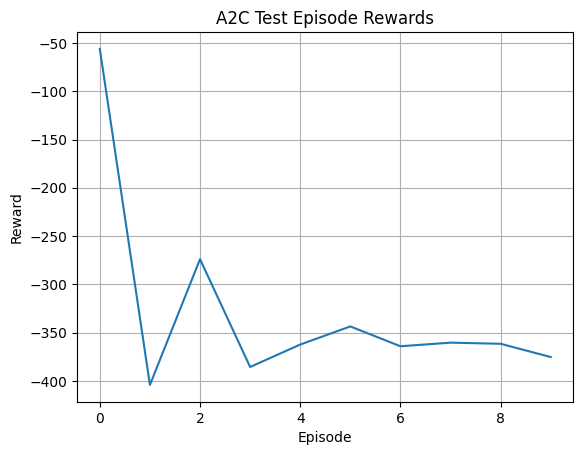

In [18]:
import matplotlib.pyplot as plt

env = gym.make('LunarLanderContinuous-v3')
test_episodes = 10
test_rewards = []

for _ in range(test_episodes):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(a2c_model.device)
            mean, std, _ = a2c_model.policy_net(state_tensor)
            action = mean
            print(action)

        next_state, reward, terminated, truncated, _ = env.step(action.cpu().numpy().squeeze(0))
        done = terminated or truncated
        ep_reward += reward
        state = next_state

    test_rewards.append(ep_reward)


print(f"Average reward over {test_episodes} test episodes: {np.mean(test_rewards):.2f}")

plt.plot(test_rewards)
plt.title("A2C Test Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


In [ ]:
import gymnasium as gym
import numpy as np


env = gym.make('LunarLanderContinuous-v3')
test_episodes = 10
random_rewards = []

for ep in range(test_episodes):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action = env.action_space.sample()  # random continuous action
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        ep_reward += reward

    random_rewards.append(ep_reward)
    print(f"Episode {ep+1} reward: {ep_reward:.2f}")

env.close()

avg_reward = np.mean(random_rewards)
print(f"\n✅ Average reward over {test_episodes} random episodes: {avg_reward:.2f}")


In [ ]:
# from tqdm import tqdm
# import torch.profiler

# n_envs = 1
# envs = [gym.make('LunarLanderContinuous-v3') for _ in range(n_envs)]

# n_states = envs[0].observation_space.shape[0]
# n_actions = envs[0].action_space.shape[0]

# actor_network = GaussianActor(n_states, n_actions)
# critic_network = Critic(n_states)

# state_normalizer = Normalizer(shape=(envs[0].observation_space.shape[0],))
# optimizer = optim.Adam(list(actor_network.parameters()) + list(critic_network.parameters()), lr=initial_lr)
# mse_loss = nn.MSELoss()

# max_step = 1600
# states, actions, log_probs, rewards, values, dones, entropies = [], [], [], [], [], [], []


# for ep in tqdm(range(episodes)):
#     states, rewards, dones, values, actions = [], [], [], [], []
#     ep_reward = 0
#     latest_debug_info = {}

#     for env in envs:
#         state, _ = env.reset()
#         done = False
#         steps = 0

#         while not done:
#             state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
#             mean, std = actor_network(state_tensor)
#             dist = torch.distributions.Normal(mean, std)
#             action = dist.sample()
#             log_prob = dist.log_prob(action).sum(dim=-1)
#             entropy = dist.entropy().sum(dim=-1)
#             value = critic_network(state_tensor)
#             steps += 1

#             next_state, reward, terminated, truncated, _ = env.step(action.detach().numpy().squeeze(0))
#             done = terminated or truncated or steps > max_step

#             states.append(state_tensor)
#             actions.append(action)
#             log_probs.append(log_prob)
#             values.append(value)
#             rewards.append(reward)
#             dones.append(done)
#             entropies.append(entropy)
#             ep_reward += reward

#             if len(rewards) >= num_steps or done:

#                 next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
#                 if dones[-1]:
#                     bootstrap_value = 0
#                 else:
#                     bootstrap_value = critic_network(next_state_tensor).item()

#                 returns = []
#                 R = bootstrap_value
#                 for i in reversed(range(len(rewards))):
#                     R = rewards[-1 - i] + gamma * R
#                     returns.insert(0, R)
#                 returns = torch.tensor(returns, dtype=torch.float32)

#                 values_tensor = torch.stack(values[-num_steps:]).squeeze(-1)
#                 log_probs_tensor = torch.stack(log_probs[-num_steps:]).squeeze(-1)
#                 entropies_tensor = torch.stack(entropies[-num_steps:]).squeeze(-1)
#                 returns_tensor = returns.clone().detach()
#                 advantages = returns - values_tensor
#                 clipped_advantages = torch.clamp(advantages, min=-10.0, max=10.0)

#                 policy_loss = -(log_probs_tensor * clipped_advantages.detach()).mean()
#                 value_loss = mse_loss(values_tensor, returns_tensor)
#                 entropy_loss = -entropies_tensor.mean()

#                 # total_loss = policy_loss + 0.5 * value_loss + 0.001 * entropy_loss
#                 total_loss = policy_loss + 0.4 * value_loss    #following rl-baselines3-zoo

#                 optimizer.zero_grad()
#                 total_loss.backward()
#                 grad_norm = torch.nn.utils.clip_grad_norm_(
#                     list(actor_network.parameters()) + list(critic_network.parameters()),
#                     max_norm=0.5
#                 )
#                 optimizer.step()


#                 latest_debug_info = {
#                     "values": values_tensor,
#                     "returns": returns,
#                     "log_probs": log_probs_tensor,
#                     "entropies": entropies_tensor,
#                     "policy_loss": policy_loss,
#                     "value_loss": value_loss,
#                     "grad_norm": grad_norm
#                 }


#                 states, actions, log_probs, rewards, values, dones, entropies = [], [], [], [], [], [], []

#             state = next_state


#     if ep % 10 == 0 and latest_debug_info:
#         a2c_debug_log(ep, steps, ep_reward, **latest_debug_info)

In [ ]:
def a2c_debug_log(ep, steps, ep_reward, values, returns, log_probs, entropies, policy_loss, value_loss, grad_norm):
    advantages = returns - values

    print(f"\n[Episode {ep}] Debug Summary")
    print(f"# of Steps:         {steps:.2f}")
    print(f"Total Reward:       {ep_reward:.2f}")
    print(f"Mean V(s):          {values.mean().item():.4f}")
    print(f"Advantage Mean:     {advantages.mean().item():.4f}")
    print(f"Advantage Std:      {advantages.std().item():.4f}")
    print(f"Entropy (avg):      {entropies.mean().item():.4f}")
    print(f"Policy Loss:        {policy_loss.item():.4f}")
    print(f"Value Loss:         {value_loss.item():.4f}")
    print(f"Gradient Norm:      {grad_norm:.4f}")
    print(f"Log Prob Mean:      {log_probs.mean().item():.4f}")
    print("-" * 50)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


# class Normalizer:
#     def __init__(self, shape, epsilon=1e-8):
#         self.shape = shape
#         self.mean = np.zeros(shape)
#         self.var = np.ones(shape)
#         self.count = epsilon

#     def update(self, x):
#         batch_mean = np.mean(x, axis=0)
#         batch_var = np.var(x, axis=0)

#         batch_size = x.shape[0]
#         self.count += batch_size
#         self.mean += (batch_mean - self.mean) * batch_size / self.count
#         self.var += (batch_var - self.var) * batch_size / self.count

#     def normalize(self, x):
#         return (x - self.mean) / np.sqrt(self.var + 1e-8)


def compute_gae(rewards, values, next_values, dones, gamma, gae_lambda):
    advantages = []
    advantage = 0
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * next_values[i] * dones[i] - values[i]
        advantage = delta + gamma * gae_lambda * dones[i] * advantage
        advantages.insert(0, advantage)
    return advantages

